In this notebook, we illustrate the reparameterized volume sampling for a single ray (i.e., in 1D). The notebook consists of four parts:

    1. Implementation of a class used to approximate density along a ray and generate samples
    2. Illustration of a coarse density approximation along with sampling (Fig. 1 in the paper)
    3. Expected color estimates and their variance evaluation (Fig. 2 in the paper)
    4. Toy optimization task to illustrate gradient learning capabilities (not in the paper)
    
# 1. Density Implementation

In [97]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.functional import softplus

import matplotlib.pyplot as plt
import matplotlib
from tqdm.notebook import tqdm

matplotlib.rcdefaults()
matplotlib.style.use('seaborn-white')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = "16"
plt.rcParams["lines.linewidth"] = "3"
plt.rcParams["legend.frameon"] = True

torch.set_default_dtype(torch.float32)

For a positive density field $\sigma_r(t)$ on a ray $r$ we take a grid $t_1 < \dots < t_m$, compute $\sigma_r(t_i), i=1,\dots,n$ and construct a piecewise linear approximation.

The support of our approximation is $(t_n, t_f)$. Based on $\sigma_r(t)$, we define

1. Transmittance $$T(t) = \exp(- \int_{t_n}^t \sigma_r(s) \mathrm d s)$$
2. Opacity $$F(t) = 1 - T(t)$$
3. Unnormalized probability density function $$p(t) = \sigma_r(t) T(t)$$
4. Inverse CDF $$F^{-1}(y_f u)$$

The support of the inverse opacity is $(y_n, y_f) = (F(t_n), F(t_f))$.

In [98]:
class PiecewiseLinearDensity(torch.jit.ScriptModule):
    
    def __init__(self, t, s):
        """Linear spline for density approximation.
        
        Args:
            t -- spline knots, tensor of shape (..., n_knots)
            s -- knot density values, tensor of shape (..., n_knots)
        """
        super().__init__()
        self.t = t
        self.s = s
        self.integrals = self._get_partial_integrals()

            
    def update_spline_parameters(self, t, s):
        """Replace grid t and density s. Allows avoiding jit recompilation."""
        self.t = t
        self.s = s
        self.integrals = self._get_partial_integrals()
        
        
    @staticmethod
    def _get_bin_values(values, indices):
        """Auxilliary function used in piecewise functions."""
        return torch.gather(values, -1, indices)

    
    def _get_partial_integrals(self,):
        """Integrate the spline from t_n to the right boundary of a each bin."""
        bin_integral = 0.5 * (self.s[..., 1:] + self.s[..., :-1]) * torch.diff(self.t)
        return torch.cumsum(bin_integral, dim=-1)
    
    
    def _get_bin_indices(self, t):
        """Return a indices of bins containing t."""
        assert(self.t.shape[:-1] == t.shape[:-1])
        indices = torch.searchsorted(self.t, t)
        indices = torch.clamp(indices, min=1)
        return indices

    
    def forward(self, t):
        """Compute linear spline at $t$
        
        Args:
            t -- spline arguments of shape (..., m)
        """
        indices = self._get_bin_indices(t)
        t_left = self._get_bin_values(self.t, indices - 1)
        t_right = self._get_bin_values(self.t, indices)
        alpha = (t_right - t) / (t_right - t_left)
        s_left = self._get_bin_values(self.s, indices - 1)
        s_right = self._get_bin_values(self.s, indices)  
        return alpha * (s_left - s_right) + s_right
        
    
    def _sigma_int(self, t):
        """ Compute spline integral $\int_{t_0}^t \sigma(s) \mathrm d s$.
        
        Args:
            t -- spline arguments of shape (..., m)
        """
        indices = self._get_bin_indices(t)
        full_part = self._get_bin_values(self.integrals, indices - 1)
        
        t_right = self._get_bin_values(self.t, indices)
        s_right = self._get_bin_values(self.s, indices)
        s = self.forward(t)
        curr_part = 0.5 * (s + s_right) * (t - t_right)
        return full_part + curr_part
    
    
    @torch.jit.script_method
    def _sigma_int_bin_inv(self, t_left, t_right, s_left, s_right, full_part, y):
        """Find inverse of $\int_{t_0}^t \sigma(s) \mathrm d s$ inside a bin"""
        a = (s_right - s_left) / (t_right - t_left)
        b = s_right
        c = 2 * (full_part - y)
        root = -c / (b + torch.sqrt((b ** 2 - a * c).abs()))
        return root
        
    
    def _sigma_int_inv(self, y):
        """Compute the inverse of sigma integral."""
        # find the bin containing the inverse
        indices = torch.searchsorted(self.integrals, y)
        indices = torch.clamp(indices, max=self.integrals.shape[-1] - 1)
        # find the inverse within the bin
        t_left = self._get_bin_values(self.t, indices)
        t_right = self._get_bin_values(self.t, indices + 1)
        s_left = self._get_bin_values(self.s, indices)
        s_right = self._get_bin_values(self.s, indices + 1)
        full_part = self._get_bin_values(self.integrals, indices)
        bin_root = self._sigma_int_bin_inv(t_left,
                                           t_right,
                                           s_left,
                                           s_right,
                                           full_part,
                                           y)
        return t_right + bin_root

    
    @torch.jit.script_method
    def _prepare_inv_int_input(self, u):
        """Compute -(log(1 + y_f u)) used in the inverse"""
        sigma_int_far = self.integrals[..., -1:]
        # truncated sample
        lse_input = torch.stack([-sigma_int_far + u.log(), (-u).log1p()], dim=-1)
        inv_args = -(torch.logsumexp(lse_input, dim=-1))
        #inv_args = torch.where(sigma_int_far < 1e-3, u * sigma_int_far, inv_args)
        inv_args = torch.where(sigma_int_far < 1e-6, u * sigma_int_far, inv_args)
        return inv_args
    
    def inv_cdf(self, u):
        """Compute the inverse cdf at $u$.
        
        We compute the inverse of the spline integral _sigma_int(t) rather
        than the opacity F(t) = 1 - exp(-_sigma_int(t)) to achieve better
        numerical stability.
        
        Args:
            y -- inverse function arguments of shape (..., m)
            n_iter -- number of iterations used in binary search
            eps -- hyperparameter used for gradient numerical stability
        """
        inv_args = self._prepare_inv_int_input(u)
        t = self._sigma_int_inv(inv_args)
        return t
    
    def transmittance(self, t):
        """Compute the transparency function at $t$."""
        sigma_int = self._sigma_int(t)
        return torch.exp(-sigma_int)

    
    def opacity(self, t):
        """Compute the opacity function at $t$."""
        sigma_int = self._sigma_int(t)
        return -torch.expm1(-sigma_int)

    
    def pdf(self, t):
        """Return the probability density function induced by spline"""
        return self.forward(t) * self.transmittance(t)
            
        
    def t_min(self):
        """Return the nearest ray point."""
        return self.t[..., :1]

    
    def t_max(self):
        """Return the farthest ray point."""
        return self.t[..., -1:]
    
    
    def y_min(self):
        """Return the infimum of opacity"""
        return torch.zeros_like(self.t[..., :1])

    @torch.jit.script_method
    def y_max(self):
        """Return the supremum of opacity"""
        return -torch.expm1(-self.integrals[..., -1:])
    
    
class PiecewiseConstantDensity(PiecewiseLinearDensity):
    
    def _get_partial_integrals(self,):
        """Integrate the spline from t_0 to the right boundary of a each bin."""
        bin_integral = self.s[..., 1:] * torch.diff(self.t)
        return torch.cumsum(bin_integral, dim=-1)
    
    
    def forward(self, t):
        """Compute pieceise constant spline at $t$
        
        Args:
            t -- spline arguments of shape (..., m)
        """
        indices = self._get_bin_indices(t)
        s_right = self._get_bin_values(self.s, indices)  
        return s_right
        
    
    def _sigma_int(self, t):
        """ Compute spline integral $\int_{t_0}^t \sigma(s) \mathrm d s$.
        
        Args:
            t -- spline arguments of shape (..., m)
        """
        indices = self._get_bin_indices(t)
        full_part = self._get_bin_values(self.integrals, indices - 1)
        
        t_right = self._get_bin_values(self.t, indices)
        s_right = self._get_bin_values(self.s, indices)
        curr_part = s_right * (t - t_right)
        return full_part + curr_part
    
    def _sigma_int_inv(self, y):
        """Compute the inverse of sigma integral.       
        """
        # find the bin containing the inverse
        indices = torch.searchsorted(self.integrals, y)
        indices = torch.clamp(indices, max=self.integrals.shape[-1] - 1)
        # find the inverse within the bin
        t_right = self._get_bin_values(self.t, indices + 1)
        s = self._get_bin_values(self.s, indices + 1)
        full_part = self._get_bin_values(self.integrals, indices)
        t = t_right - (full_part - y) / (s + 1e-16)
        return t
    
Density = PiecewiseConstantDensity

For our experiments, we also define a class for a random function. Given the class, we start with a sanity check for a random density field.

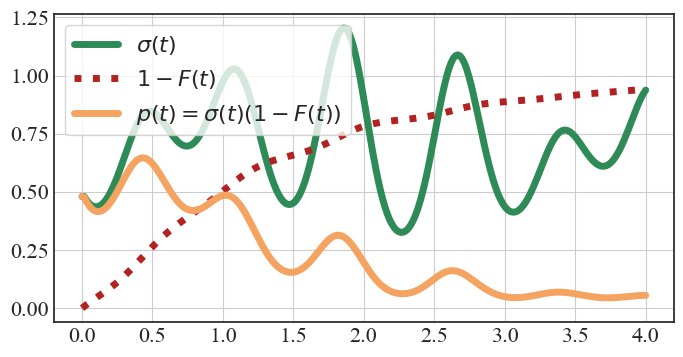

In [99]:
class RandomFunction(nn.Module):
    def __init__(self, n_features=8):
        """Create a random function."""
        super().__init__()
        self.alpha = torch.randn(n_features) / (n_features) ** (0.5)
        self.w = 2 * np.pi * torch.randn(n_features)
        self.b = 2 * np.pi * torch.rand(n_features)
        
    def forward(self, t):
        features = torch.cos(self.w * t.unsqueeze(-1) + self.b)
        return (self.alpha * features).sum(-1)
    
# sanity check
torch.manual_seed(111)
t = torch.linspace(0, 4, 256)
f = RandomFunction(n_features=4)
sigma = Density(t, softplus(f(t)))

t_grid = torch.linspace(0, 4, 256)
plt.figure(figsize=(8, 4))
plt.plot(t_grid, sigma(t_grid), label='$\sigma(t)$', color='seagreen', lw=5)
plt.plot(t_grid, sigma.opacity(t_grid), label='$1 - F(t)$', ls='dotted', color='firebrick', lw=5)
plt.plot(t_grid, sigma.pdf(t_grid), label='$p(t) = \sigma(t) (1 - F(t))$', color='sandybrown', lw=5)
plt.grid()
plt.legend();

# 2. Density Approximation & Sampling

We pick a random function and construct a spline approximation on a coarse grid (left) as an illustration. Using the coarse approximation, we compute the approximate opacity to generate a few ray samples.

In [100]:
torch.manual_seed(112)
# initize the groundtruth density
t = torch.linspace(0, 2, 256)
f = RandomFunction(n_features=4)
sigma = Density(t=t,
                s=softplus(f(t)))

# initialzie a coarse spline approximation
t_coarse = torch.linspace(0, 2, 8)
sigma_spline_pwc = PiecewiseConstantDensity(
    t=t_coarse,
    s=sigma(t_coarse - 0.5 * torch.diff(t_coarse, prepend=torch.Tensor([0.]))))
sigma_spline_pwl = PiecewiseLinearDensity(t=t_coarse, s=sigma(t_coarse))

# generate a few ray points
u = torch.rand(8)  # start with the uniform samples
y_min = sigma_spline_pwl.y_min()  # get the initial ray opacity
y_max = sigma_spline_pwl.y_max()  # get the overall ray opacity
y_samples = y_min + (y_max - y_min) * u  # scale y if y_min != 0 or y_max != 1
t_samples = sigma_spline_pwl.inv_cdf(u)

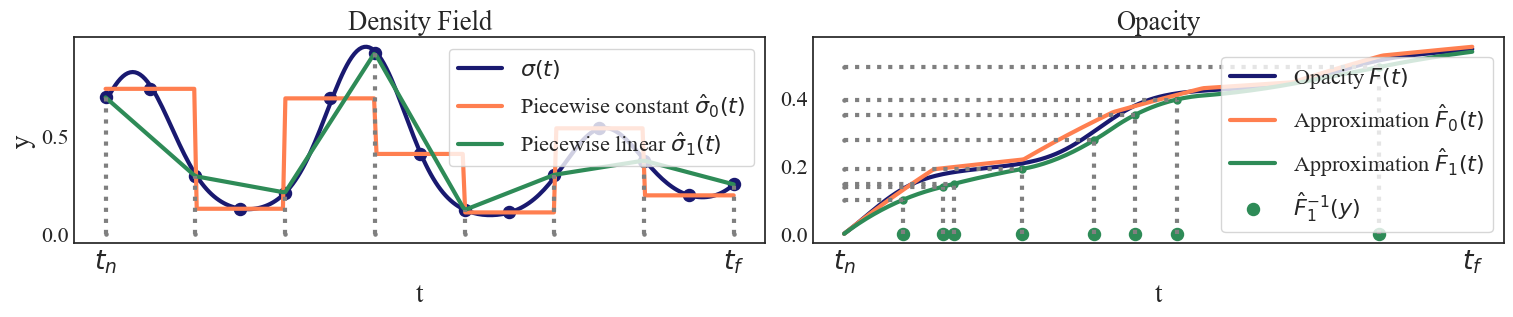

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3), constrained_layout=True)

t_grid = torch.linspace(0, 2, 256)
# spline illustration
ax1.plot(t_grid, sigma(t_grid), label='$\sigma(t)$', color='midnightblue')
ax1.plot(t_grid, sigma_spline_pwc(t_grid), label='Piecewise constant $\hat{\sigma}_0(t)$', color='coral')
ax1.plot(t_grid, sigma_spline_pwl(t_grid), label='Piecewise linear $\hat{\sigma}_1(t)$', color='seagreen')


ax1.scatter(t_coarse, sigma_spline_pwl(t_coarse), s=75, color='midnightblue')
ax1.scatter(t_coarse[1:] - 0.5 * torch.diff(t_coarse),
            sigma_spline_pwc(t_coarse[1:] - 0.5 * torch.diff(t_coarse)),
            s=75, color='midnightblue')
for knot, knot_y in zip(t_coarse, sigma(t_coarse)):
    t_i = np.array([knot, knot])
    y_i = np.array([0., knot_y])
    ax1.plot(t_i, y_i, c='tab:gray', ls='dotted')
ax1.scatter(t_coarse, torch.zeros_like(t_coarse), s=5, color='tab:gray')

ax1.set_title('Density Field')
ax1.set_ylabel('y', size='large')
ax1.set_xlabel('t', size='large')
ax1.set_xticks((t_grid.min(), t_grid.max()))
ax1.set_xticklabels(('$t_n$', '$t_f$'), size='large')
ax1.legend(loc='upper right')

# samapling illustration
t_grid = sigma.t_min() + (sigma.t_max() - sigma.t_min()) * torch.linspace(0, 1, 256)
ax2.plot(t_grid, sigma.opacity(t_grid), label='Opacity $F(t)$', color='midnightblue')
ax2.plot(t_grid, sigma_spline_pwc.opacity(t_grid), label='Approximation $\hat{F}_0(t)$', color='coral')
ax2.plot(t_grid, sigma_spline_pwl.opacity(t_grid), label='Approximation $\hat{F}_1(t)$', color='seagreen')

ax2.scatter(t_samples, y_samples, s=25, color='seagreen')
for t_sample, y_sample in zip(t_samples, y_samples):
    ax2.plot(np.array([0., t_sample]), np.array([y_sample, y_sample]), c='tab:gray', ls='dotted')
    ax2.plot(np.array([t_sample, t_sample]), np.array([0., y_sample]), c='tab:gray', ls='dotted')
ax2.scatter(torch.zeros_like(y_samples), y_samples, color='tab:gray', s=5)
ax2.scatter(t_samples, torch.zeros_like(t_samples), color='seagreen', s=75, label='$\hat{F}_1^{-1}(y)$')

ax2.set_title('Opacity')
ax2.set_xlabel('t', size='large')
ax2.set_xticks((t_grid.min(), t_grid.max()))
ax2.set_xticklabels(('$t_n$', '$t_f$'), size='large')
ax2.legend(loc='lower right')

plt.savefig('spline_inversion.pdf')

plt.show()

# 3. Expected Color Estimates

In this part, we estimate the expected radiance $C = \mathbb E_T c(T) = \int_{t_n}^{t_f} c(t) \mathrm d F(t)$ for the radiance field $c$ and the opacity $F(t)$ induced by the density field $\sigma$.

We consider four estimates:

1. Monte-Carlo estimate with uniform $t$ samples $t_1, \dots, t_k$ from $U(t_n, t_f)$: $$C_{MC}^t =\frac{1}{k}\sum_{i=1}^{k} (t_f - t_n) p(t_i) c(t_i)$$
2. Stratified Monte-Carlo estimate with $t$ samples $t_1, \dots, t_k$ from a uniform grid $t_i = t_n + (t_f - t_n)u_i,\ u_i \sim U(\frac{i - 1}{k}, \frac{i}{k})$: $$C_{SMC}^t = \frac{1}{k} \sum_{i=1}^{k} (t_f - t_n) p(t_i) c(t_i)$$
3. Monte-Carlo estimate with $y$ samples $y_1, \dots, y_k$ from $U(y_n, y_f)$: $$C_{MC}^y =\frac{1}{k}\sum_{i=1}^{k} (y_f - y_n) c(F^{-1}(y_i)) $$
4. Stratified Monte-Carlo estimate with $y$ samples $y_1, \dots, y_k$ from a uniform grid $y_i = y_n + (y_f - y_n)u_i,\ u_i \sim U(\frac{i - 1}{k}, \frac{i}{k})$: $$C_{SMC}^y = \frac{1}{k} \sum_{i=1}^{k} (y_f - y_n) c(F^{-1}(y_i)) $$

Estimates #1 and #2 are importance weighted estimates obtained with naive sampling algorithms for ray points. Note that estimate #2 can be seen as rectangular rule sum with widths $\frac{t_f - t_n}{m}$ and noisy heights $p(t_i)c(t_i)$.

As opposed to estimates #1 and #2, we propose a reparameterized sampling algorithm for the underlying density function $p(t)$ and obtain estimates #3 and #4. Sampling is based on the inverse opacity $F^{-1}(y)$ implemented in `Density` class.

In [102]:
def jiggle_grid(grid):
    """Return m uniform samples within m corresponding grid bins."""
    lower = grid[..., :-1]
    upper = grid[..., 1:]
    jiggled_grid = lower + (upper - lower) * torch.rand_like(lower) 
    return jiggled_grid

def baseline_estimate(k, sigma, f, batch_size=None):
    u_grid = torch.linspace(0, 1, k + 1)
    #u_grid = u_grid.unsqueeze(-2).repeat(batch_size, 1)
    t_grid = sigma.t.min() + u_grid * (sigma.t.max() - sigma.t.min())
    #t_grid = jiggle_grid(t_grid)
    summands = f(t_grid[1:]) * (sigma.opacity(t_grid[..., 1:]) - sigma.opacity(t_grid[..., :-1]))
    return summands.sum(-1, keepdim=True)
    
def t_mc_estimate(k, sigma, f, batch_size=32):
    """Return Monte Carlo expected color estimate with uniform ray samples."""
    u = torch.rand(batch_size * k)
    t_min = sigma.t_min()
    t_max = sigma.t_max()
    t = t_min + u * (t_max - t_min)
    summands = (t_max - t_min) * sigma.pdf(t) * f(t)
    return summands.reshape(batch_size, k).mean(-1)

def t_stratified_mc_estimate(k, sigma, f, batch_size=32):
    """Return expected color estimate with stratified ray samples."""
    u_grid = torch.linspace(0, 1, k + 1)
    u_grid = u_grid.unsqueeze(-2).repeat(batch_size, 1)
    t_grid = sigma.t.min() + u_grid * (sigma.t.max() - sigma.t.min())
    jiggled_t_grid = jiggle_grid(t_grid).flatten()
    summands = ((t_grid[..., 1:] - t_grid[..., :-1])
                * (sigma.pdf(jiggled_t_grid) * f(jiggled_t_grid)).reshape(batch_size, k))
    return summands.sum(-1)

def y_mc_estimate(k, sigma, f, batch_size=32):
    """Return Monte Carlo expected color estimate with density induced samples."""
    u = torch.rand(batch_size * k)
    t = sigma.inv_cdf(u)
    summands = (sigma.y_max() - sigma.y_min()) * f(t)
    return summands.reshape(batch_size, k).mean(-1)


def y_stratified_mc_estimate(k, sigma, f, batch_size=32):
    """Return stratified expected color estimate with density induced samples."""
    u_grid = torch.linspace(0, 1, k + 1)
    u_grid = u_grid.unsqueeze(-2).repeat(batch_size, 1)
    jiggled_u_grid = jiggle_grid(u_grid)
    jiggled_t_grid = sigma.inv_cdf(jiggled_u_grid.flatten()).reshape(batch_size, k)
    y_min = sigma.y_min()
    y_max = sigma.y_max()
    summands = ((y_max - y_min) * (u_grid[..., 1:] - u_grid[..., :-1]) * f(jiggled_t_grid))
    return summands.sum(-1)

We illustrate the estimates with a random radiance function and three density fields. 

- "Foggy" density field represents a semi-transparent volume;
- "Glass and Wall" represents a volume where a ray has a small chance of being emitted in one region of a 1D line (glass surface) and a high chance of being emitted in another region of the line
- "Wall" density field represents a volume where a ray is emitted for a single tiny region of the line.

In [103]:
def get_density(density_type):
    """Create a density field."""
    t = torch.linspace(0, 1, 256)
    s = -torch.ones(256)
    if density_type == 'Wall':
        s[128:132] = 4
    elif density_type == 'Glass and Wall':
        s[192:196] = 4
        s[38:40] = 0.2
        s[44:46] = 0.2
    elif density_type == 'Foggy':
        s[32:234] = 0.1
    return Density(t, softplus(64 * s))

def compute_estimate(estimator, sigma, f, k_min, k_max, batch_size):
    """Compute estimates and aggregate statistics"""
    stats = torch.zeros(k_max - k_min + 1, 2)
    for k_index, k in enumerate(range(k_min, k_max + 1)):
        integral = estimator(k, sigma, f, batch_size)
        stats[k_index, 0] = integral.mean()
        stats[k_index, 1] = integral.std()        
    return stats

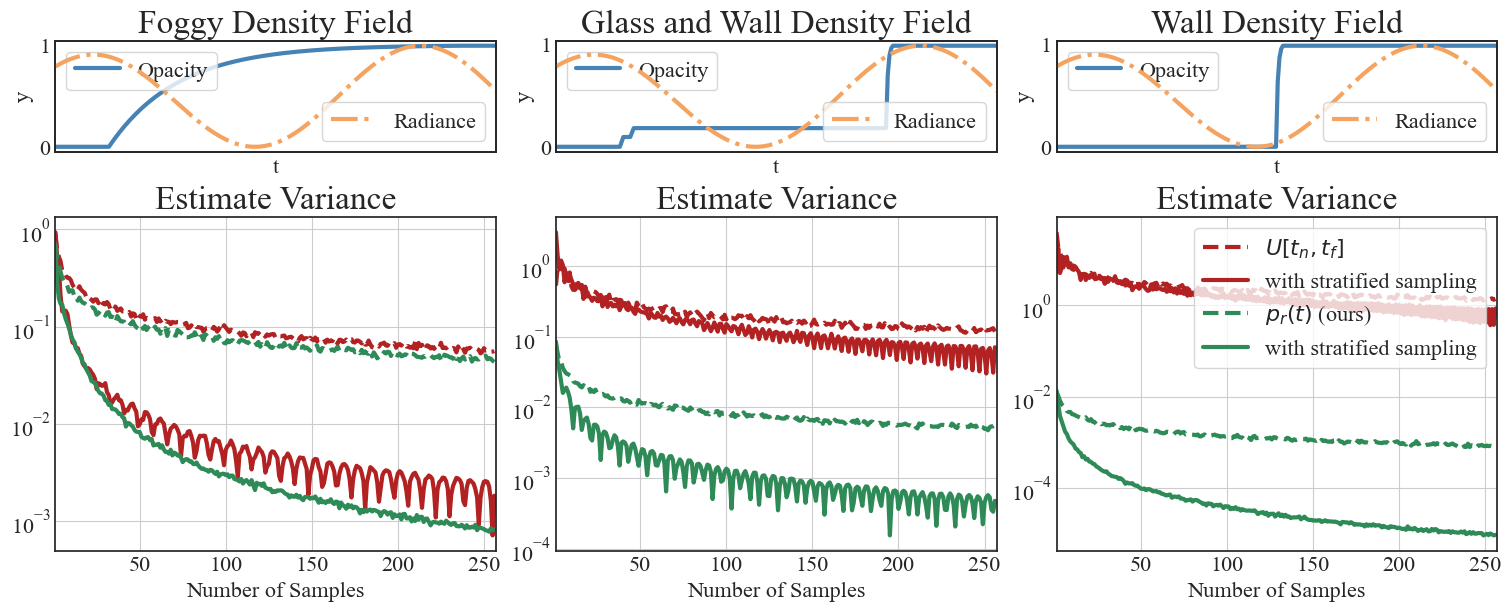

In [104]:
# density illustration
torch.manual_seed(111)
k_min = 1
k_max = 256
batch_size = 256

radiance = RandomFunction(n_features=4)

density_types = ['Foggy', 'Glass and Wall', 'Wall',]


fig, axes = plt.subplots(2, 3,
                         figsize=(15,6),
                         gridspec_kw={'height_ratios': [1, 3]},
                         constrained_layout=True)


for plot_index, density_type in enumerate(density_types):
    # plot density & radiance
    sigma = get_density(density_type)
    t_grid = sigma.t_min() + (sigma.t_max() - sigma.t_min()) * torch.linspace(0, 1, 256)
    opacity = sigma.opacity(t_grid)
    
    ax1, ax2 = axes[:, plot_index]
    ax1_right = ax1.twinx()

    ax1.plot(t_grid, opacity, label='Opacity', c='steelblue')
    ax1_right.plot(t_grid, f(t_grid), label='Radiance', c='sandybrown', ls='dashdot')

    ax1.set_title(density_type + ' Density Field', fontsize=24)
    ax1.set_xlabel('t')
    ax1.set_ylabel('y')
    ax1.set_xlim((0., 1.))
    ax1.set_xticks([])
    ax1.set_yticks([0, 1])
    ax1_right.set_yticks([])
    ax1_right.legend(loc='lower right')
    ax1.legend(loc='upper left')

    # compute & plot variances
    t_mc = compute_estimate(t_mc_estimate, sigma, f, k_min, k_max, batch_size)
    t_stratified = compute_estimate(t_stratified_mc_estimate, sigma, f, k_min, k_max, batch_size)
    
    y_mc = compute_estimate(y_mc_estimate, sigma, f, k_min, k_max, batch_size)
    y_stratified = compute_estimate(y_stratified_mc_estimate, sigma, f, k_min, k_max, batch_size)
    
    k_range = range(k_min, k_max + 1)
    ax2.plot(k_range, t_mc[:, 1], label='$U[t_{n}, t_{f}]$', color='firebrick', ls='dashed')
    ax2.plot(k_range, t_stratified[:, 1], label='with stratified sampling', color='firebrick')
    ax2.plot(k_range, y_mc[:, 1], label='$p_r(t)$ (ours)', color='seagreen', ls='dashed')
    ax2.plot(k_range, y_stratified[:, 1], label='with stratified sampling', color='seagreen')

    ax2.set_yscale('log')
    ax2.set_title('Estimate Variance', fontsize=24)
    ax2.grid()
    ax2.set_xlabel('Number of Samples')
    ax2.set_xlim((k_min, k_max + 1))
    
    if density_type == 'Wall':
        ax2.legend(loc='upper right')

plt.show()

# 4. Density Optimization

Finaly, we illustrate gradient optimization capabilities of `Density` with a toy optimization task inspired by intergral probability metrics.

The task goal is to recover a random density field $\sigma$ with gradient-based optimization. Density field $\sigma$ induces a random variable $T$ on a line. Additionally, we define a variational field $\hat \sigma$ that induces a random variable $S$. To achieve the goal we optimize the average discrepancy between a random statistic $\phi$ computed for $T$ and for $S$:
$$\min_{\hat \sigma} \mathcal{L}(\hat{\sigma}, \sigma) = \mathbb E_\phi \|\mathbb E_{T \sim P_\sigma} \phi(T) - E_{S \sim P_{\hat\sigma}} \phi(S)\|_2^2$$

For the expectations we use stratified reparameterized estimates.

In [105]:
# to get an unbiased estimate of a squared norm we get
# two expectation estimates and multiply them. note that
# with biased estimates lead to poor density reconstruction
unbiased_square_estimate = True
estimate = y_stratified_mc_estimate
#estimate = t_stratified_mc_estimate
k = 8  # number of samples

torch.manual_seed(100)

n_steps = 20000
n_plots = 10
lr = 1e-3

pbar = tqdm(range(n_steps))
losses_ema = []
intermediate_sigma = []

# initialize optimization objective \sigma
t = torch.linspace(0, 1, 256)
f_target = RandomFunction(n_features=32)
sigma_target = Density(t, softplus(f_target(t)))

# initialize parameters of \hat{\sigma}
spline_parameters = nn.Parameter(-1 * torch.ones_like(t))
sigma_ours = Density(t, softplus(spline_parameters))

optimizer = torch.optim.Adam([spline_parameters,], lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for n in pbar:
    # compute loss & make a gradient step
    optimizer.zero_grad()
    sigma_ours.update_spline_parameters(t, softplus(spline_parameters))
    
    phi = RandomFunction(n_features=32)
    mean_target = estimate(256, sigma_target, phi, batch_size=1)
    if unbiased_square_estimate:
        mean_ours = estimate(k, sigma_ours, phi, batch_size=2)
        x = (mean_ours[0] - mean_target)
        y = (mean_ours[1] - mean_target)
        loss = 1024 * (x * y).sum()
    else:
        mean_ours = estimate(k, sigma_ours, phi, batch_size=1)
        loss = 1024 * ((mean_target - mean_ours) ** 2).sum()
    loss.backward()
    optimizer.step()
    if n % 5000 == 0:
        scheduler.step()
    # log
    if n == 0:
        loss_ema = loss.detach()
    else:
        loss_ema = (1 - 0.01) * loss_ema + 0.01 * loss.detach()
    losses_ema.append(loss_ema)
    if n % (n_steps // n_plots) == 0:
        intermediate_sigma.append(sigma_ours(t).detach())
    pbar.set_description_str('Error EMA: {:.5f}'.format(loss_ema))

  0%|          | 0/20000 [00:00<?, ?it/s]

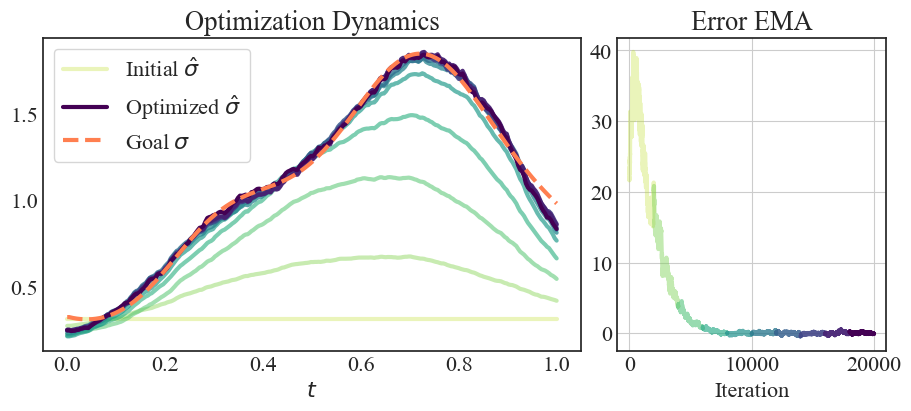

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4), constrained_layout=True, gridspec_kw={'width_ratios': [2, 1]})

cmap = matplotlib.cm.get_cmap('viridis')

for n, sigma_n in enumerate(intermediate_sigma):
    alpha = 0.1 + 0.9 * (n / n_plots)
    ax1.plot(t, sigma_n, c=cmap(1 - alpha), alpha=alpha ** 0.5,
             label='Initial $\hat{\sigma}$' if n == 0 else None)


for alpha, indices, losses in zip(np.linspace(0.1, 1, n_plots),
                                  np.array_split(np.arange(len(losses_ema)), n_plots),
                                  np.array_split(losses_ema, n_plots)):
    ax2.plot(indices, losses, c=cmap(1 - alpha), alpha=alpha ** 0.5,)

ax1.plot(t, sigma_ours(t).detach(), label='Optimized $\hat{\sigma}$', c=cmap(0.))
ax1.plot(t, sigma_target(t), label='Goal $\sigma$', color='coral', ls='dashed')
ax1.legend()
ax2.grid()
ax1.set_title('Optimization Dynamics')
ax1.set_xlabel('$t$')
ax2.set_xlabel('Iteration')
ax2.set_title('Error EMA');